# GPz_Pype: How-to for the basic features and usage

In [1]:
import numpy as np
import os

# Plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Astropy modules
from astropy.table import Table, join, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u

# Import required gpz_pype functions
from gpz_pype.utilities import Params, set_gpz_path, basic_lupt_soft, flux_to_lupt
from gpz_pype.base import GPz
from gpz_pype.gmm import GMMbasic

# # Other modules - might not be required
# import subprocess
# import pickle

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz >= 0.)

    dz = photoz - specz
    abs_dz = np.abs(dz)/(1+specz)

    p90 = (abs_dz < np.percentile(abs_dz, 90.))
    sigma_90 = np.sqrt(np.sum((dz[p90]/(1+specz[p90]))**2) / float(len(dz)))

    bias = np.nanmedian(dz[cut]/(1+specz[cut]))
    ol1 = (abs_dz > 0.15)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (abs_dz > (3*nmad))
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))
    
    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return nmad, sigma_90, OLF1, bias

For this example notebook we will use the CANDELS COSMOS catalogue as an input. This includes lots of photometry from both ground + space, but we will restrict analysis to just the HST filters for simplicity (and to mimic the likely limitations of some JWST fields).

Inputting the catalogue into GPz however requires some additional pre-processing. We start by extracting the general common columns and setting any missing `z_spec` values to `np.nan`:

In [2]:
candels = Table.read('CANDELS.COSMOS.F160W.Processed.photz.fits', format='fits')

catalogue = candels[['ID', 'RA', 'DEC', 'CLASS_STAR', 'FLAGS', 'EBV', 'z_spec']]

catalogue['z_spec'][catalogue['z_spec'] < 0] = np.nan

To further trim the catalogue down, i next want to pull out only the flux/magnitude columns that belong to HST filters. In this case, columns that start with either 'ACS' or 'WFC'. As with `z_spec`, any value set as -99 in the input catalogue (i.e. no data) is converted to `np.nan`:

In [3]:
for col in candels.colnames:
    if col.startswith('ACS') or col.startswith('WFC'):
        inst, filt, ext = col.split('_') # Split column name into 3 parts based on '_'
        col_vals = candels[col]
        col_vals[col_vals < -90] = np.nan
        catalogue[f'{ext}_{filt}'] = col_vals # [FLUX/FLUXERR]_[FILTER]

To extract the filters that were found in the catalogue, we reprocess the column names to look for filters. This could have been done above, but since there were both MAG/FLUX columns this would have resulted in duplicates. So this is simpler:

In [4]:
filters = [col.split('_')[1] for col in catalogue.colnames if col.startswith('FLUX_')]

### Asinh magnitudes
Extensive past experience has shown that training machine learning using magnitudes can provide significantly better results than using linear flux values. This is particularly true for fields with very high dynamic range, such as HST/JWST deep fields with extremely sensitive observations.

However, the significant drawback of normal AB magnitudes is that they cannot be used at low S/N or for negative fluxes (consistent with zero). For GPz we therefore make use of asinh magnitudes, which remain real+positive for very low S/N that remain informative for non-detections without the need for additional missing value prediction etc. This is particularly key for high-redshift where the non-detection at bluer wavelengths is critical for the redshift estimate.

Ideally, the softening parameter ($b$) used to derive asinh magnitudes from fluxes + uncertainties will be derived from the local noise on a per-object basis. However, when these are not available the use of a global softening parameter does not significantly impact photo-z results. 

For convenience, `gpz_pype` includes a function for estimating a suitable global softening parameter based on a set of input fluxes+errors (_that are assumed to be representative of the full field_):

In [5]:
# Calculate a softening parameter for each filter in the list of filters derived above:
b_arr = [basic_lupt_soft(catalogue[f'FLUX_{filt}'], catalogue[f'FLUXERR_{filt}']) for filt in filters] 

With softening parameters calculated, we can then calculate the asinh magnitudes (also known as 'luptitudes') for each of our filters. These can be calculated using the `flux_to_lupt` function included in `gpz_pype`.

In [6]:
# Make a new catalogue with the relevant key reference columns:
lupt_cols = catalogue[['ID', 'RA', 'DEC', 'CLASS_STAR', 'FLAGS', 'EBV', 'z_spec']]

check_nans = np.zeros(len(catalogue)) # Running counter of null values for each object

for filt, b in zip(filters, b_arr):
    lupt, lupterr = flux_to_lupt(catalogue[f'FLUX_{filt}'], # Input flux (uJy)
                                 catalogue[f'FLUXERR_{filt}'], # Input uncertainty (uJy)
                                 b, # Filter specific softening parameter
                                ) 
    
    lupt_cols[f'lupt_{filt}'] = lupt
    lupt_cols[f'lupterr_{filt}'] = lupterr
    
    check_nans += np.isnan(lupt) # Update nan counter for this filter

After filling all the columns, for the purpose of training GPz we want to cut our catalogue down to those sources with values in all the filters we want to use and for which there is a spectroscopic redshift:

In [7]:
good = (check_nans == 0) # 'Good' sources for training are those with 0 NaNs

cat = lupt_cols[good * (np.isnan(lupt_cols['z_spec']) == False)] # Keep only good sources with z_spec

## Running GPz through `gpz_pype`

The following code assumes that `gpz++` is correctly installed on the system and that it can be run through the command line without issue. The `gpz_pype` classes simply wrap around `gpz++` and streamline the book-keeping required when using more complicated splitting+weighting of training sample.

The path to `gpz++` can be set as a system variable so this step might not be required in future. It can also be input directly into the `GPz` class below, but for safety we can use the convenience function `set_gpz_path` to set this for the current session.

In [8]:
set_gpz_path('/Users/duncan/Astro/Photoz/gpzpp/bin/gpz++')

The main workhorse of `gpz_pype` is the `GPz` class, it needs to be instantiated with a set of parameters that we can then update manually (and which `GPz` will automatically set for us when necessary).
We can also define the number of CPUs we want `gpz++` to make use of during training:

In [9]:
test = GPz(param_file='/Users/duncan/Astro/Photoz/gpzpp/example/gpz.param', ncpu=4)

In [10]:
test.params['REUSE_MODEL'] = '0'

To perform GPz training on an input catalogue in gpz++ in our most straight-forward approach, we can use the `.run_training` function from the `GPz` class.

Even in its most straight-forward approach, there are lots of options that must be set. Many of which can be left as their degault value. I have tried to ensure that in-code documentation for `gpz_pype` is relatively complete, so the full set of options available can be seen using the standard python help functionality, e.g.:

In [11]:
help(test.run_training)

Help on method run_training in module gpz_pype.base:

run_training(catalog, outdir, basename, gmm_output=None, bash_script=False, mag_prefix='mag_', error_prefix='magerr_', z_col='z_spec', id_col='id', weight_col=None, output_min=0, output_max=7, test_fraction=0.2, valid_fraction=0.2, do_iteration=False, iter_cov='gpvc', total_basis_functions=100, bf_distribution='uniform', min_basis_functions=10, max_iter=500, tol=1e-09, grad_tol=1e-05, verbose=False, **kwargs) method of gpz_pype.base.GPz instance
    Run GPz training and prediction for a given input catalogue.
    
    Parameters
    ----------
    catalog : astropy.table.Table, str
        Catalog to run GPz on. If str, will read in catalog from file.
    outdir : str
        Output directory.
    basename : str
        Basename for output files.
    gmm_output : astroy.table.Table
        GMM divide and/or weight output catalog.
    bash_script: bool
        If True, output gpz++ commands to a bash script instead of running.
    ma

In [12]:
outdir = 'test_dir'

if not os.path.isdir(outdir):
    os.mkdir(outdir)

simple_run, paths = test.run_training(
      cat, # Run training on this input catalogue - can be a path or a Table object
      outdir=outdir, # Save training/output catalogues in this directory
      basename='candels_cosmos', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt_', # Look for these asinh magnitude columns
      error_prefix='lupterr_', # Look for these error columns
      id_col='ID', # ID column to propagate into output files
      total_basis_functions=100, # NUMBF passed to gpz++
      do_iteration=False, # If True, run second iteration with more complex covariance
      verbose=False, # Don't print all of the gpz++ output to screen. Turn on for debugging
    )

There are two outputs from `.run_training`:

1. Catalogue: The 'test' subset of the input catalogue, with `gpz++` prediction columns appended:

In [ ]:
simple_run.show_in_notebook()

idx,id,RA,DEC,CLASS_STAR,FLAGS,EBV,z_spec,lupt_F606W,lupterr_F606W,lupt_F814W,lupterr_F814W,lupt_F125W,lupterr_F125W,lupt_F160W,lupterr_F160W,value,uncertainty,var.density,var.tr.noise,var.in.noise
0,15266,150.1429631,2.3619418,0.0,0,0.01659,0.5714,24.52883823327196,0.04723692486480872,23.913445461845466,0.029530564003645073,23.707135619595075,0.029677588877705982,23.577236502247512,0.022986424788445106,0.7265713,0.6207663,0.001027507,0.3798481,0.004475247
1,20627,150.1004527,2.4285972,0.0,0,0.01724,2.4743,25.300054120223535,0.08957512576711295,25.309215397411364,0.0936409188959733,25.232310784429234,0.09343830613800469,24.991281572939105,0.06589175531935193,3.008879,0.8344352,0.0144995,0.6634218,0.01836069
2,19499,150.1489234,2.4131586,0.03,0,0.01685,0.9329,24.69235914321448,0.09717408078201746,23.49371484162387,0.03896766578824247,22.661886313894577,0.014999892581786321,22.404209869938445,0.010313304876806538,0.907361,0.1844638,0.0003378126,0.03172816,0.001960941
3,1566,150.0548821,2.1982057,0.03,0,0.01935,2.297,25.450845432324304,0.19376880049340514,24.703183662288396,0.12002064887878384,22.68162859529824,0.017306165375218518,21.72802070009796,0.007063464047715692,1.764402,0.3517278,0.004679031,0.08919224,0.02984116
4,9762,150.1787245,2.2962067,0.0,0,0.01688,1.6393,24.60310535147678,0.04972949493964586,24.549142673072684,0.05563874294673754,23.675079736498787,0.03748252032021332,23.68301313825319,0.03309439000025911,1.767443,0.2664152,0.0007898859,0.0556923,0.0144949
5,16142,150.1521657,2.3720099,0.02,0,0.01657,1.1771,25.577953886538506,0.11590661967398337,24.6537006110944,0.053939272266771116,23.710136702575998,0.030285281274726746,23.26537128369009,0.017800571590806075,1.367655,0.4484159,0.001041272,0.1907895,0.009245974
6,21159,150.0680672,2.4262669,0.03,3,0.01743,0.6552,20.07366142253541,0.010612531342782764,20.301241308129697,0.012769190503202346,20.142440225462195,0.008346361438030381,19.780988202097195,0.005358655437754841,-0.1019185,0.2723282,0.006529478,0.06755997,7.320274e-05
7,14771,150.1562795,2.3558409,0.0,0,0.01662,2.6012,24.38457829507185,0.0703803563831012,24.335002308157502,0.07541805263789464,23.419691946600434,0.038413290649703766,22.984880566745552,0.023762517250984837,2.263079,0.4425385,0.001354584,0.1543058,0.04018002
8,5199,150.0623211,2.2386355,0.03,2,0.0193,1.1676,23.311529860630923,0.06999419970363283,22.14035123631284,0.037247997759740165,20.863218318641582,0.0064485986610605785,20.44370569867106,0.0038500458583241763,0.9791016,0.2642562,0.001066685,0.06750667,0.001257989
9,15510,150.137843,2.3640178,0.02,2,0.01658,0.2056,23.62690722769849,0.036414250951449484,23.002948057344625,0.02296938453040759,22.620970964850006,0.017752795946153185,22.498195069844495,0.01377867773896807,0.7512145,0.2810881,0.0003395416,0.07747791,0.001193068


2. Output paths: A dictionary containing the relative paths to the various files produced from the gpz++ training - including both input catalogues (in gpz format) and the trained model + associated parameter file:

In [ ]:
paths

### Plotting outputs
Just for validation purposes, lets plot the predicted photo-$z$ versus spec-$z$ for the test catalogue. We can see that between $1 < z < 3$ the predictions do a decent job, even with just the 4-bands used in training. But at low and high redshifts the performance falls off

Text(0, 0.5, '$z_{\\rm{phot}}$')

/var/folders/4h/l82f8_jx1476t0k78sdtfq5w0000gn/T/ipykernel_20468/3209683446.py:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


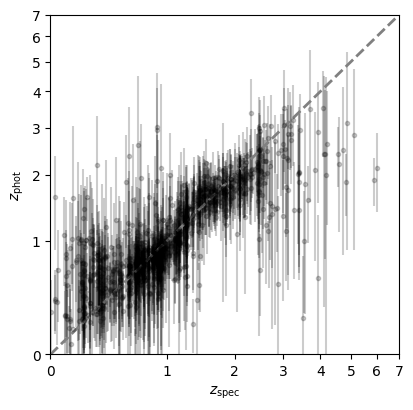

In [15]:
# Function x**(1/2)
def forward(x):
    return np.log10(1+x)

def inverse(x):
    return (10**x) - 1

Fig, Ax = plt.subplots(1,1,figsize=(4.5,4.5))

Ax.errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)
Ax.set_xlim([0, 7])
Ax.set_ylim([0, 7])

Ax.set_yscale('function', functions=(forward, inverse))
Ax.set_xscale('function', functions=(forward, inverse))


Ax.plot([0, 7], [0, 7], '--', color='0.5', lw=2)
Ax.set_xlabel(r'$z_{\rm{spec}}$')
Ax.set_ylabel(r'$z_{\rm{phot}}$')

## Example GMM Divide + Cost-sensitive Learning Calculations

The basic functionality for the Gaussian Mixture Model (GMM) sample division and cost-sensitive learning is contained in the `GMMbasic` class. The training of the respective GMMs is done internally within the class, and is effectively a wrapper around the [sci-kit learn/GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) classes with all its functionality.

The key inputs that we need to define for `GMMbasic` are as follows:

- `X_pop` : The feature array for the reference population.
- `X_train` : The feature array for the training sample.
- `Y_train` : The labels for the training sample (i.e. the spectroscopic redshifts).
- `ncomp` : Number of mixtures used for the GMM model.

For building the mixture models, we need to manually decide on and create a set of features (`X_pop`/`X_train`) with which we want to represent our sample. The 'best' features will be dependent on the input data, the scientific goals etc. These also do not necessarily need to be features used in the GPz training (e.g. luptitudes), or even things derived from luptitudes. 

In the following example, given the limited number of features we will just use a combination of colours and magnitudes. But sizes or morphological information could also be sensible choices.

Since for our example the training set is a subset of the reference population, we can define one set of features and then split:

In [16]:
gmm_features = np.array([lupt_cols['lupt_F606W']-lupt_cols['lupt_F814W'],
                         lupt_cols['lupt_F814W']-lupt_cols['lupt_F125W'],
                         lupt_cols['lupt_F160W']]).T

X_pop = gmm_features[good] # The full reference population 
                           # (i.e. representative of the full sample we would like photo-z predictions for)
X_train = gmm_features[good * (np.isnan(lupt_cols['z_spec']) == False)] # The training subset

Instantiating the class with the inputs defined above will build the GMMs:

In [17]:
gmm = GMMbasic(X_pop=X_pop, 
               X_train=X_train, 
               Y_train=cat['z_spec'], 
               ncomp=4) # For larger samples and more features, more mixtures could be appropriate

## GMM Weight

Since the cost-sensitive learning (CSL) is the most straight-forward to include in `gpz++`, we will first generate some CSL weights based on the GMMs we have just produced. To do so is as straight-forward as:

In [18]:
weights = gmm.calc_weights(X_train, X_pop, max_weight=100)

In principle, we could go straight to running GPz with these inputs. But its first useful to verify that the weights are producing sensible results. And if necessary, to quantitatively compare how well different features perform when trying to match the target distribution.

For the feature set we defined earlier, we can simply plot the distributions of the training sample features, $x_{i}$, before and after weighting is applied:

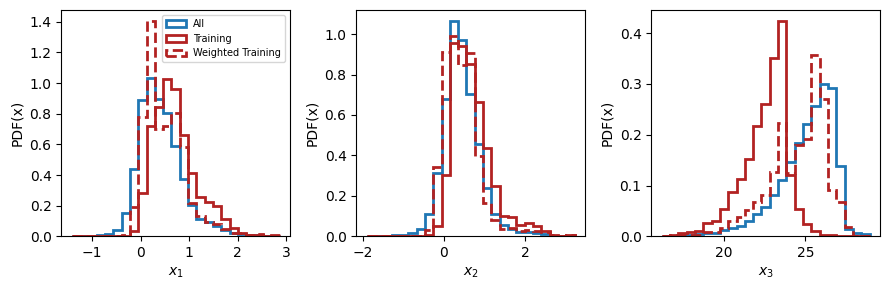

In [19]:
Fig, Ax = plt.subplots(1,3, figsize=(9,3))

Ax = Ax.flatten()

for i, ax in enumerate(Ax):
    c, bins, _ = ax.hist(X_pop[:,i], density=True, bins=25, 
                      range=np.percentile(X_pop[:,i], [0.1, 99.9]), histtype='step', lw=2,
                        label='All')
    ax.hist(X_train[:,i], density=True, bins=bins, histtype='step', lw=2, color='firebrick',
            label='Training')
    ax.hist(X_train[:,i], density=True, bins=bins, histtype='step', lw=2, color='firebrick', 
            ls='--', weights=weights,
            label='Weighted Training')

    ax.set_ylabel('PDF(x)')
    ax.set_xlabel(f'$x_{i+1}$')

Ax[0].legend(loc='upper right', prop={'size':7})
Fig.tight_layout()

Although not perfect, we can see that the fainter training sources have been significantly up-weighted when compared to the original distribution. The colours are also distributed more like those of the full sample.

To include the weights in GPz we can simply add them to our input catalogue and tell GPz to include them in the training:

In [20]:
cat['weights'] = weights # Add the weights to our previous catalogue

weights_run, paths = test.run_training( # All of these as above but with minor changes
      cat, 
      outdir='test_dir', 
      basename='candels_cosmos_weighted', # Change the prefix to keep separate
      bash_script=False,
      mag_prefix='lupt_',
      error_prefix='lupterr_', 
      id_col='ID',
      total_basis_functions=100,
      do_iteration=False, 
      verbose=False,
      weight_col='weights', # Now weight training by this column
    )

/var/folders/4h/l82f8_jx1476t0k78sdtfq5w0000gn/T/ipykernel_20468/3209683446.py:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


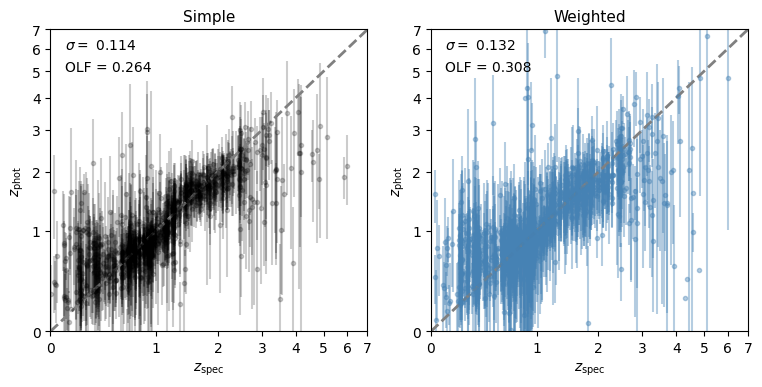

In [21]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))

Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(weights_run['z_spec'], weights_run['value'], 
            yerr=weights_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['Simple', 'Weighted']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_weight = calcStats(weights_run['z_spec'], weights_run['value'])

stats = [stats_simple, stats_weight]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 7])
    ax.set_ylim([0, 7])
    
    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 7], [0, 7], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$z_{\rm{spec}}$')
    ax.set_ylabel(r'$z_{\rm{phot}}$')
    ax.set_title(labels[i], size=11)
    
    ax.text(0.1, 6.0, f'$\sigma = $ {stats[i][0]:.3f}')
    ax.text(0.1, 5.0, f'OLF = {stats[i][2]:.3f}')



At face value, the weights have not resulted in an overall statistical improvement to the photo-$z$ estimates. But by eye, there is definitely some improvement at the higher redshift end. For now, we move onto the GMM-Divide option.

## GMM Divide

Dividing the training sample into different mixtures is as equally simple. For this example with its relatively small sample sizes, the number of training sources that could end up assigned to a mixture could be very small. We therefore will lower the threshold above which a source will be assigned to a mixture to 0.2, approximately saying that the source has at least a 20% chance of belonging to that mixture. (Note the default 0.5 effectively assigns each source to its best match)

In [22]:
train_mixtures = gmm.divide(X_train[:,:], 
                            weight=False, # Do not include CSL weights yet
                            threshold=0.5) # Change the divide threshold

cat['weights'] = 1. # Re-set the weights to be equal

# Save for later
train_mixtures.write('cosmos_mixtures_ex.csv', format='ascii.csv', overwrite=True)

In [ ]:
gmm_output = Table.read('cosmos_mixtures_ex.csv', format='ascii.csv')

divide_run, paths = test.run_training(cat, outdir='test_dir', 
                         basename='candels_cosmos_divide',
                         gmm_output=gmm_output,
                         bash_script=False,
                         weight_col='weights',
                         mag_prefix='lupt_', 
                         error_prefix='lupterr_', id_col='ID',
                         total_basis_functions=100, do_iteration=False, verbose=False)

GPz++ Run (mixture 1/4):   0%|                                                    | 0/4 [00:00<?, ?it/s]

As above, lets compare the results between the simple and GMM divided runs:

/var/folders/4h/l82f8_jx1476t0k78sdtfq5w0000gn/T/ipykernel_50355/3209683446.py:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


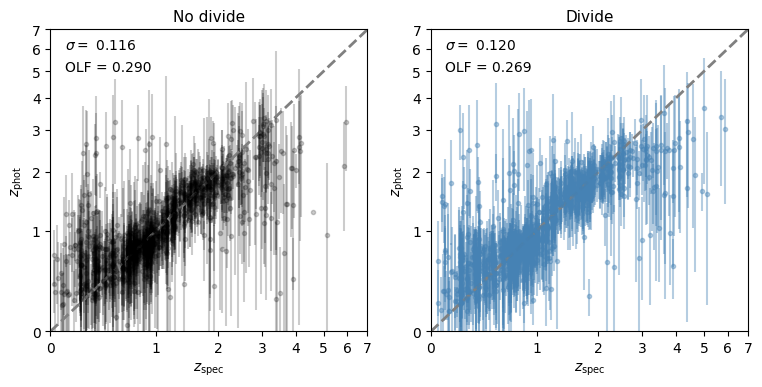

In [29]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))

Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(divide_run['z_spec'], divide_run['value'], 
            yerr=divide_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['No divide', 'Divide']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_divide = calcStats(divide_run['z_spec'], divide_run['value'])

stats = [stats_simple, stats_divide]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 7])
    ax.set_ylim([0, 7])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 7], [0, 7], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$z_{\rm{spec}}$')
    ax.set_ylabel(r'$z_{\rm{phot}}$')
    ax.set_title(labels[i], size=11)
    
    ax.text(0.1, 6.0, f'$\sigma = $ {stats[i][0]:.3f}')
    ax.text(0.1, 5.0, f'OLF = {stats[i][2]:.3f}')   

This time we can see that overall outlier fraction and scatter are now improved. Visually, we can also see that the high-redshift end is also significantly improved. 

Lets now do a run using both the GMM Divide and Weights. This can be done using the divide option, but setting `weight = True` in the options. To prevent confusion, we will also now remove the weight column we added above, since the weights will now be propagated through the catalogue included as `gmm_output`:

In [31]:
train_mixtures2 = gmm.divide(X_train[:,:], 
                            weight=True,
                            threshold=0.2)

if 'weights' in cat.colnames:
    cat.remove_columns(['weights'])  # Weights will be taken from the GMM outputs file now instead

Run the gpz training as normal:

In [32]:
combined_run, paths = test.run_training(cat, outdir='test_dir', 
                         basename='candels_cosmos_both',
                         gmm_output=train_mixtures2,
                         bash_script=False,
                         weight_col='weights',
                         mag_prefix='lupt_', 
                         error_prefix='lupterr_', id_col='ID',
                         total_basis_functions=100, do_iteration=False, verbose=False)

GPz++ Run (mixture 4/4): 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]


/var/folders/4h/l82f8_jx1476t0k78sdtfq5w0000gn/T/ipykernel_50355/3209683446.py:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


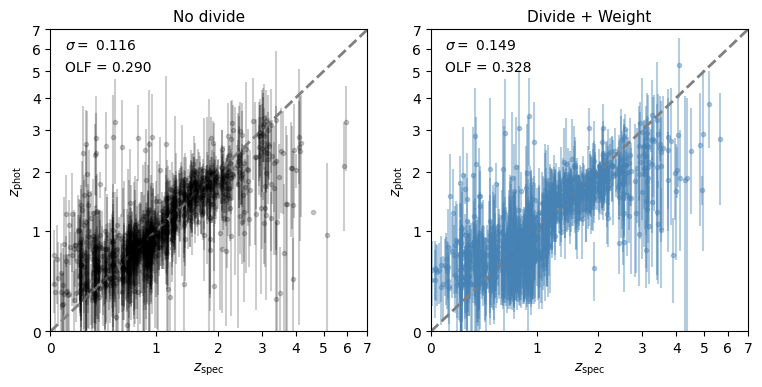

In [33]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))

Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(combined_run['z_spec'], combined_run['value'], 
            yerr=combined_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['No divide', 'Divide + Weight']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_combined = calcStats(combined_run['z_spec'], combined_run['value'])

stats = [stats_simple, stats_combined]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 7])
    ax.set_ylim([0, 7])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 7], [0, 7], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$z_{\rm{spec}}$')
    ax.set_ylabel(r'$z_{\rm{phot}}$')
    ax.set_title(labels[i], size=11)
    
    ax.text(0.1, 6.0, f'$\sigma = $ {stats[i][0]:.3f}')
    ax.text(0.1, 5.0, f'OLF = {stats[i][2]:.3f}')   

Compared to the Divide-only run, our combined Divide+Weights is performing slightly worse for the two metrics we have chosen, but is still an improvement over the Weight-only option. So in this case, using only the GMM-Divide would be the optimal approach. But as training sample sizes increase and additional features are added to the GPz training, this might not remain the case.

Additionally, since the spectroscopic sample is obviously biased, the Weight/Divide+Weight runs might actually provide better statistics for the overall galaxy population (at the expense of the brigher sources). Assessing the statistics as a function of e.g. spectroscopic redshift or magnitude can start to make these assessments clearer.